https://github.com/zyxue/stanford-cs229/blob/master/previous_cs229/notes3-support-vector-machines-SMO-algorithm.ipynb

http://cs229.stanford.edu/notes/cs229-notes3.pdf

# Understanding

### Functional margin ($\hat \gamma$) and geometric margin ($\gamma$)

Definition for the functional margin of data point $x^{(i)}$:

$$\hat \gamma^{(i)} = y^{(i)}(w^T x^{(i)} + b)$$

Given $y^{(i)}$ is $\pm 1$ for the positive and negative examples, $\hat \gamma^{(i)}$ is actually equivalent to

$$| w^T x^{(i)} + b |$$

which is a scaled distance of $x$ to the line (verified by geometry)

$$w^T x^{(i)} + b = 0 $$ 

and the scaler is $\left\|w\right\|$. 

If we let $x_0$ be the vector that is perpendicular (hence $x_0$ is more specific to the $B$ shown in the lecture note) to the line, and also exactly on the line. Then $b$ can be written as 

$$b=-\left\|w\right\| \left\|x_0 \right\|$$

$\hat \gamma$ can also be written in terms of $x_0$. To sum up:

\begin{align*}
\hat \gamma^{(i)} &= y^{(i)}(w^T x^{(i)} + b)\\
            &= |w^T x^{(i)} + b| \\
            &= y^{(i)}w^T(x^{(i)} - x_0)
\end{align*}

Note when $\left\|w\right\| = 1$. $\hat \gamma$ becomes the unscaled distance, i.e. the **geometric margin** ($\gamma$, no hat).


In the context of a **training set** with multiple data points ($x^{(1)}$, $x^{(2)}$, $\cdots$, $x^{(m)}$), we define the functional margin of the training set ($\hat \Gamma$) to be 

$$\hat \Gamma = \mathrm{min}_{i=i,\cdots,m} \hat \gamma^{(i)}$$

Note in the lecture notes, they use $\hat \gamma$ to represent the functional margin of a training set, but I feel it rather confusing as $\hat \gamma{(i)}$ has already been used for the functional margin of individual data point, so I choose to use upper case $\hat \Gamma$, which feels less confusing. Similarly, the geometric margin of a training set would be $\Gamma$ without the hat sign.

### SVM

After some reasoning: the SVM becomes an optimization problem for the following optimal margin classifier:

$$
\mathrm{min}_{\gamma, w, b} \frac{1}{2}\left\|w\right\|^2
$$
Subject to:
$$y^{(i)}(w^Tx^{(i)} + b) \ge 1, i = 1, 2, \cdots, m$$

Here we enforced the functional margin to be exactly one ($\hat \gamma = 1$) after after scaling $w$ and $b$. Meanwhile, we want to minimize $\left\|w\right\|$.

**Important to think through**: this is equivalent to maximizing the geometric margin when enforcing $\left\|w\right\| = 1$, given which, $y^{(i)}(w^Tx^{(i)} + b)$ can be interpreted as exactly the distance to the decision boundary.

Recall 

$$\hat \gamma^{(i)} = y^{(i)}(w^T x^{(i)} + b)$$

It's just about either

1. fix $f(w) = \left\|w\right\| = 1$ involved in the right hand, maximize the left hand (the original idea behind maximum margin)
1. fix left hand (because scaling $w$ and $b$ won't affect decision boundry line), minimize $f(w) = \left\|w\right\|$ which is involved in the right hand

The two approaches have the same effect as to which decision boundry will be selected after the optimization.

Applying Lagrange duality (non-trivial, esp. for the linearly unseparable cases), the optimization problem becomes

$$
\mathrm{max}_{\alpha} W(\alpha) = \sum_{i=1}^{m} \alpha_i - \frac{1}{2} \sum_{i,j=1}^{m}y^{(i)}y^{(j)} \alpha_i \alpha_j x_i^T x_j
$$
Subject to:
$$0 \le \alpha_i \le C, i = 1, 2, \cdots, m$$
and
$$\sum_{i=1}^{m} \alpha_i y^{(i)} = 0$$


Sequential Minimal optimization (SMO) algorithm is a relatively recent way to solve the above optimization problem. There are other ways, too. See John Platt's paper: https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/smo-book.pdf. SMO is also implemented in [libsvm](https://en.wikipedia.org/wiki/LIBSVM).

# Implementation

Follow http://cs229.stanford.edu/materials/smo.pdf

e.g. while optimizaing $\alpha_1, \alpha_2$, fix the other $\alpha$s,

\begin{align*} 
W(\alpha) &= \alpha_1 + \alpha_2 + \sum_{i=3}^{m} \alpha_i + \frac{1}{2} [\\
          &y_1^2 \alpha_1^2 x_1^T x_1 + \\
          &y_2^2 \alpha_2^2 x_2^T x_2 + \\
          &y_1 y_2 \alpha_1 \alpha_2 x_1^T x_2 + \\
          &y_2 y_1 \alpha_2 \alpha_1 x_2^T x_1 + \\
          &\sum_{j=3}^{m} y_1 y_j \alpha_1 \alpha_j x_1^T x_j + \\
          &\sum_{j=3}^{m} y_2 y_j \alpha_2 \alpha_j x_2^T x_j + \\
          &\sum_{i=3}^{m} y_i y_1 \alpha_i \alpha_1 x_i^T x_1 + \\
          &\sum_{i=3}^{m} y_i y_2 \alpha_i \alpha_2 x_i^T x_2 + \\
          &\sum_{i=3,j=3}^{m} y_i y_j \alpha_i \alpha_j x_i^T x_j \\
]
\end{align*}

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# toy dataset
Xs = np.array([
        [0.5, 0.5],
        [1, 1],
        [1.5, 2],
        [2, 1]
    ])
ys = [-1, -1, 1, 1]

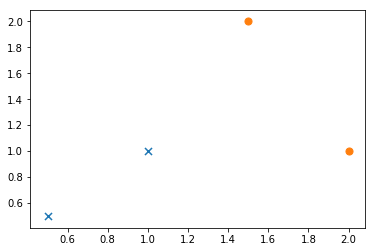

In [3]:
plt.scatter(*Xs[:2].T, marker='x', s=50)
plt.scatter(*Xs[2:].T, marker='o', s=50)

In [31]:
def calc_f(xk, alphas, Xs, ys, b):
    return np.dot(alphas * ys, Xs.dot(xk)) + b

In [19]:
def calc_E(xk, yk, alphas, Xs, ys, b):
    return calc_f(xk, alphas, Xs, ys, b) - yk

In [20]:
def calc_L(yi, yj, ai, aj, C):
    if yi != yj:
        return max(0, aj - ai)
    elif yi == yj:
        return max(0, ai + aj - C)
    else:
        raise
        
def calc_H(ai, aj, yi, yj, C):
    if yi != yj:
        return min(C, aj - ai + C)
    elif yi == yj:
        return min(C, ai + aj)
    else:
        raise

In [21]:
def update_aj(aj, yj, Ei, Ej, eta, H, L):
    """Eq. 12 and 15"""
    aj = aj - yj * (Ei - Ej) / eta
    if aj > H:
        return H
    elif aj < L:
        return L
    else:
        return aj

def update_ai(ai, yi, yj, aj_old, aj):
    """Eq. 16"""
    return ai + yi * yj * (aj_old - aj)

In [22]:
def calc_b(b1, b2, ai, aj, C):
    if 0 < ai < C:
        return b1
    elif 0 < aj < C:
        return b2
    else:
        return (b1 + b2) / 2

In [23]:
# the toy example is linearly separable, so C could be arbitrarily large
C = 1e8
tol = 0.001
max_passes = 10000

m = Xs.shape[0]
alphas = np.zeros(m)
b = 0

In [24]:
passes = 0
while passes < max_passes:
#     print(passes, end=',')
    num_changed_alphas = 0
    for i in range(m):
        ai = alphas[i]
        xi = Xs[i]
        yi = ys[i]
        Ei = calc_E(xi, yi, alphas, Xs, ys, b)
        if (yi * Ei < -tol and ai < C) or (yi * Ei > tol and ai > 0):
            j = np.random.choice([_ for _ in range(m) if _ != i])
            aj = alphas[j]
            xj = Xs[j]
            yj = ys[j]
            Ej = calc_E(xj, yj, alphas, Xs, ys, b)
            
            ai_old = ai
            aj_old = aj
            
            L = calc_L(ai, aj, yi, yj, C)
            H = calc_H(ai, aj, yi, yj, C)
            if L == H:
                continue
                
            eta = 2 * xi.dot(xj) - xi.dot(xi) - xj.dot(xj)
            if eta >= 0:
                continue
                
            aj = update_aj(aj, yj, Ei, Ej, eta, H, L)
            alphas[j] = aj
            if np.abs(aj - aj_old) < 1e-5:
                continue
            
            ai = update_ai(ai, yi, yj, aj_old, aj)
            alphas[i] = ai
            
            # Eq. 17
            b1 = b - Ei - yi * (ai - ai_old) * xi.dot(xi) - yj * (aj - aj_old) * xi.dot(xj)
            # Eq. 18
            b2 = b - Ej - yi * (ai - ai_old) * xi.dot(xj) - yj * (aj - aj_old) * xj.dot(xj)
            b = calc_b(b1, b2, ai, aj, C)
            num_changed_alphas += 1
    if num_changed_alphas == 0:
        passes += 1
    else:
        passes = 0
#     print(num_changed_alphas, passes, end=',')

In [25]:
alphas

array([0.        , 2.50070131, 0.99953246, 1.50116885])

In [26]:
b

-4.000467541196802

In [27]:
# np.array([alphas[i] * ys[i] * Xs[i] for i in range(m)]).sum(axis=0)
# most alphas should be 0
ws = sum([alphas[i] * ys[i] * Xs[i] for i in range(m)])

In [28]:
norm_ws = ws / np.sqrt(ws.dot(ws))
(norm_ws**2).sum()

0.9999999999999998

In [29]:
margin = np.min(np.abs(Xs.dot(ws) + b) / np.sqrt(ws.dot(ws)))

(0, 2.2)

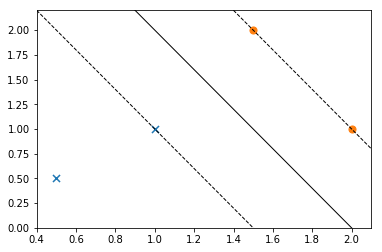

In [30]:
_x1s = np.array([0, 3])
_x2s = (-b - ws[0] * _x1s) / ws[1]
_xs = np.array([_x1s, _x2s]).T
assert (_xs[1] - _xs[0]).dot(ws) < 1e-12

# decision boundary
plt.plot(*_xs.T, lw=1, color='black')
# margin
plt.plot(*(_xs - norm_ws * margin).T, color='black', lw=1, linestyle='--')
plt.plot(*(_xs + norm_ws * margin).T, color='black', lw=1, linestyle='--')

plt.scatter(*Xs[:2].T, marker='x', s=50)
plt.scatter(*Xs[2:].T, marker='o', s=50)

plt.xlim(0.4, 2.1)
plt.ylim(0, 2.2)

When I first see this margin, it looks so beautiful, and feels so good it works! 🍺